In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from scipy import stats
from scipy.signal import hilbert,convolve,hann
     
from sklearn.linear_model import LinearRegression

In [2]:
import sys

In [3]:
import tensorflow as tf

In [4]:
import keras
import keras.backend as K
from keras.models import Sequential,Model
from keras.layers import LSTM,Dense

Using TensorFlow backend.


In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
pd.set_option('precision',30)

In [7]:
train_df=pd.read_csv('F:\\Qplus\\Kaggle\\train.csv',chunksize=5000000,iterator=True,
                     dtype={'acoustic_data':np.int16,'time_to_failure':np.float32})

In [8]:
def create_many_features(xc,seg_id=0):
    X=pd.DataFrame(index=[seg_id,])
    zc=np.fft.fft(xc)
    
    X.loc[seg_id,'mean']=xc.mean()
    X.loc[seg_id,'std']=xc.std()
    X.loc[seg_id,'max']=xc.max()
    X.loc[seg_id,'min']=xc.min()
    
    #FFT transform values
    realFFT = np.real(zc)
    imagFFT = np.imag(zc)
    X.loc[seg_id, 'Rmean'] = realFFT.mean()
    X.loc[seg_id, 'Rstd'] = realFFT.std()
    X.loc[seg_id, 'Rmax'] = realFFT.max()
    X.loc[seg_id, 'Rmin'] = realFFT.min()
    X.loc[seg_id, 'Imean'] = imagFFT.mean()
    X.loc[seg_id, 'Istd'] = imagFFT.std()
    X.loc[seg_id, 'Imax'] = imagFFT.max()
    X.loc[seg_id, 'Imin'] = imagFFT.min()
    
    X.loc[seg_id, 'Rmean_last_5000'] = realFFT[-5000:].mean()
    X.loc[seg_id, 'Rstd__last_5000'] = realFFT[-5000:].std()
    X.loc[seg_id, 'Rmax_last_5000'] = realFFT[-5000:].max()
    X.loc[seg_id, 'Rmin_last_5000'] = realFFT[-5000:].min()
    X.loc[seg_id, 'Rmean_last_15000'] = realFFT[-15000:].mean()
    X.loc[seg_id, 'Rstd_last_15000'] = realFFT[-15000:].std()
    X.loc[seg_id, 'Rmax_last_15000'] = realFFT[-15000:].max()
    X.loc[seg_id, 'Rmin_last_15000'] = realFFT[-15000:].min()
    
    X.loc[seg_id, 'std_first_50000'] = xc[:50000].std()
    X.loc[seg_id, 'std_last_50000'] = xc[-50000:].std()
    X.loc[seg_id, 'std_first_10000'] = xc[:10000].std()
    X.loc[seg_id, 'std_last_10000'] = xc[-10000:].std()
    
    X.loc[seg_id, 'avg_first_50000'] = xc[:50000].mean()
    X.loc[seg_id, 'avg_last_50000'] = xc[-50000:].mean()
    X.loc[seg_id, 'avg_first_10000'] = xc[:10000].mean()
    X.loc[seg_id, 'avg_last_10000'] = xc[-10000:].mean()
    
    X.loc[seg_id, 'min_first_50000'] = xc[:50000].min()
    X.loc[seg_id, 'min_last_50000'] = xc[-50000:].min()
    X.loc[seg_id, 'min_first_10000'] = xc[:10000].min()
    X.loc[seg_id, 'min_last_10000'] = xc[-10000:].min()
    
    X.loc[seg_id, 'max_first_50000'] = xc[:50000].max()
    X.loc[seg_id, 'max_last_50000'] = xc[-50000:].max()
    X.loc[seg_id, 'max_first_10000'] = xc[:10000].max()
    X.loc[seg_id, 'max_last_10000'] = xc[-10000:].max()
    
    X.loc[seg_id, 'abs_max'] = np.abs(xc).max()
    X.loc[seg_id, 'abs_min'] = np.abs(xc).min()
    X.loc[seg_id, 'avg_diff'] = np.mean(np.diff(xc))
    #X.loc[seg_id, 'avg_diff_rate'] = np.mean(np.nonzero((np.diff(xc) / xc[:-1]))[0]) #seems do not help
    
    X.loc[seg_id, 'q95'] = np.quantile(xc, 0.95)
    X.loc[seg_id, 'q99'] = np.quantile(xc, 0.99)
    X.loc[seg_id, 'q05'] = np.quantile(xc, 0.05)
    X.loc[seg_id, 'q01'] = np.quantile(xc, 0.01)
    
    X.loc[seg_id, 'abs_q95'] = np.quantile(np.abs(xc), 0.95)
    X.loc[seg_id, 'abs_q99'] = np.quantile(np.abs(xc), 0.99)
    X.loc[seg_id, 'abs_q05'] = np.quantile(np.abs(xc), 0.05)
    X.loc[seg_id, 'abs_q01'] = np.quantile(np.abs(xc), 0.01)
    
    X.loc[seg_id, 'trend'] = add_trend_feature(xc)
    X.loc[seg_id, 'abs_trend'] = add_trend_feature(xc, abs_values=True)
    X.loc[seg_id, 'abs_mean'] = np.abs(xc).mean()
    X.loc[seg_id, 'abs_std'] = np.abs(xc).std()
    
    X.loc[seg_id, 'mad'] = xc.mad()
    X.loc[seg_id, 'kurt'] = xc.kurtosis()
    X.loc[seg_id, 'skew'] = xc.skew()
    X.loc[seg_id, 'med'] = xc.median()
    
    X.loc[seg_id, 'Hilbert_mean'] = np.abs(hilbert(xc)).mean()
    X.loc[seg_id, 'Hann_window_mean'] = (convolve(xc, hann(150), mode='same') / sum(hann(150))).mean()
    X.loc[seg_id, 'classic_sta_lta1_mean'] = classic_sta_lta(xc, 500, 10000).mean()
    X.loc[seg_id, 'classic_sta_lta2_mean'] = classic_sta_lta(xc, 5000, 100000).mean()
    X.loc[seg_id, 'classic_sta_lta3_mean'] = classic_sta_lta(xc, 3333, 6666).mean()
    X.loc[seg_id, 'classic_sta_lta4_mean'] = classic_sta_lta(xc, 10000, 25000).mean()
    
    X.loc[seg_id, 'Moving_average_700_mean'] = xc.rolling(window=700).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_1500_mean'] = xc.rolling(window=1500).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_3000_mean'] = xc.rolling(window=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_6000_mean'] = xc.rolling(window=6000).mean().mean(skipna=True)
    
    ewma = pd.Series.ewm
    X.loc[seg_id, 'exp_Moving_average_300_mean'] = (ewma(xc, span=300).mean()).mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_3000_mean'] = ewma(xc, span=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_30000_mean'] = ewma(xc, span=6000).mean().mean(skipna=True)
    
    no_of_std = 2
    X.loc[seg_id, 'MA_700MA_std_mean'] = xc.rolling(window=700).std().mean()
    X.loc[seg_id,'MA_700MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X.loc[seg_id,'MA_700MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    
    X.loc[seg_id, 'MA_400MA_std_mean'] = xc.rolling(window=400).std().mean()
    X.loc[seg_id,'MA_400MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id,'MA_400MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id, 'MA_1000MA_std_mean'] = xc.rolling(window=1000).std().mean()
    
    X.loc[seg_id, 'iqr'] = np.subtract(*np.percentile(xc, [75, 25]))
    X.loc[seg_id, 'q999'] = np.quantile(xc,0.999)
    X.loc[seg_id, 'q001'] = np.quantile(xc,0.001)
    X.loc[seg_id, 'ave10'] = stats.trim_mean(xc, 0.1)
    
    for windows in [10, 100, 1000]:
        x_roll_std = xc.rolling(windows).std().dropna().values
        x_roll_mean = xc.rolling(windows).mean().dropna().values
        
        X.loc[seg_id, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X.loc[seg_id, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X.loc[seg_id, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X.loc[seg_id, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X.loc[seg_id, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X.loc[seg_id, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X.loc[seg_id, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X.loc[seg_id, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X.loc[seg_id, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X.loc[seg_id, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X.loc[seg_id, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X.loc[seg_id, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X.loc[seg_id, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X.loc[seg_id, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X.loc[seg_id, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X.loc[seg_id, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X.loc[seg_id, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X.loc[seg_id, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X.loc[seg_id, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X.loc[seg_id, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()
    return X

In [9]:
#generate features for a list of acoustic data
def gen_features_list(acd_list):
    train_features=pd.DataFrame()
    for acd in acd_list:
        train_features=train_features.append(create_many_features(acd),ignore_index=True)
    #print(train_features.shape)
    return train_features

In [10]:
def split_segments(acd_segments,ttf_segments,split_length):
    length=len(acd_segments)
    #split each complete segements into many small segments
    split_segments_index=np.array_split(np.arange(length),length//split_length)
    print('the length of this segments is %d'%len(split_segments_index))
    acd_split=[]
    ttf_split=pd.Series()
    for indices in split_segments_index:
        acd_split.append(pd.Series(acd_segments[indices]))
        ttf_split=ttf_split.append(pd.Series(ttf_segments[indices][-1]),ignore_index=True)
    #print(len(acd_split))
    return acd_split,ttf_split

In [11]:
def add_trend_feature(arr,abs_values=False):
    index=np.arange(len(arr))
    if abs_values:
        arr=np.abs(arr)
    lr=LinearRegression()
    lr.fit(index.reshape(-1,1),arr)
    return lr.coef_[0]

In [12]:
def classic_sta_lta(x,length_sta,length_lta):
    sta=np.cumsum(x**2)
    sta=np.require(sta,dtype=np.float)
    
    lta=sta.copy()
    
    sta[length_sta:]=sta[length_sta:]-sta[:-length_sta]
    sta/=length_sta
    
    lta[length_lta:]=lta[length_lta:]-lta[:-length_lta]
    lta/=length_lta
    
    sta[:length_sta-1]=0
    
    dtiny=np.finfo(0.0).tiny
    idx=lta<dtiny
    lta[idx]=dtiny
    return sta/lta
    
    
    

In [13]:

train_X=pd.DataFrame()
train_y=pd.Series()
acd_to_be_extended=np.array([])
ttf_to_be_extended=np.array([])
last=math.inf
split_length=100000
for chunk in train_df:
    acd=chunk.acoustic_data.values
    ttf=chunk.time_to_failure.values
    #split_index=[]   #record the index for segmentation
    split_index=np.array([])
    if ttf[0]>last:
        #split_index.append[0]
        acd_split,ttf_split=split_segments(acd_to_be_extended,ttf_to_be_extended,split_length)      
        train_X=train_X.append(gen_features_list(acd_split),ignore_index=True)
        train_y=train_y.append(ttf_split,ignore_index=True)
        acd_to_be_extended=np.array([])
        ttf_to_be_extended=np.array([])
        
    find_split=ttf[1:]>ttf[:-1]
    #split_index.append(np.where(find_split))
    split_index=np.append(split_index,np.where(find_split))
    length=len(split_index.tolist())
    if length!=0:     #which means a segment split exists
        print(length)
        print(split_index)
        acd_to_be_extended=np.append(acd_to_be_extended,
                                     acd[:int(split_index[0]+1)])
        ttf_to_be_extended=np.append(ttf_to_be_extended,ttf[:int(split_index[0]+1)])
        acd_split,ttf_split=split_segments(acd_to_be_extended,ttf_to_be_extended,split_length)
        train_X=train_X.append(gen_features_list(acd_split),ignore_index=True)
        train_y=train_y.append(ttf_split,ignore_index=True)
        #print(train_X.describe())
        #print(train_y.describe())
        acd_to_be_extended=np.array([])
        ttf_to_be_extended=np.array([])
        
        for i in range(length-1):
            acd_to_be_extended=acd[int(split_index[i])+1:int(split_index[i+1])+1]
            ttf_to_be_extended=ttf[int(split_index[i])+1:int(split_index[i+1])+1]
            acd_split,ttf_split=split_segments(acd_to_be_extended,ttf_to_be_extended,split_length)
            train_X=train_X.append(gen_features_list(acd_split),ignore_index=True)
            train_y=train_y.append(ttf_split,ignore_index=True)
            acd_to_be_extended=np.array([])
            ttf_to_be_extended=np.array([])
        acd_to_be_extended=acd[int(split_index[-1]):]
        ttf_to_be_extended=ttf[int(split_index[-1]):]
        
    else:
        acd_to_be_extended=np.append(acd_to_be_extended,acd)
        ttf_to_be_extended=np.append(ttf_to_be_extended,ttf)
    last=ttf[-1]

1
[656573.]
the length of this segments is 56
1
[85877.]
the length of this segments is 444
1
[4677355.]
the length of this segments is 545
1
[3772452.]
the length of this segments is 340
1
[2641819.]
the length of this segments is 488
1
[3652629.]
the length of this segments is 310
1
[829584.]
the length of this segments is 271
1
[2838916.]
the length of this segments is 620
1
[3276286.]
the length of this segments is 304
1
[377847.]
the length of this segments is 371
1
[4368879.]
the length of this segments is 439
1
[1811622.]
the length of this segments is 424
1
[800224.]
the length of this segments is 339
1
[3777114.]
the length of this segments is 329
1
[568143.]
the length of this segments is 567
1
[1985672.]
the length of this segments is 364


In [14]:
train_X.shape

(6211, 145)

In [15]:
train_X.describe()

,mean,std,max,min,Rmean,Rstd,Rmax,Rmin,Imean,Istd,...,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
count,6211.000000000000000000000000000000,6211.000000000000000000000000000000,6211.00000000000000000000000000000,6211.000000000000000000000000000000,6211.000000000000000000000000000000,6211.000000000000000000000000000000,6211.000000000000000000000000000000,6211.000000000000000000000000000000,6211.000000000000000000000000000000,6211.000000000000000000000000000000,...,6211.000000000000000000000000000000,6211.000000000000000000000000000000,6211.000000000000000000000000000000,6211.000000000000000000000000000000,6211.000000000000000000000000000000,6211.000000000000000000000000000000,6211.000000000000000000000000000000,6211.000000000000000000000000000000,6211.000000000000000000000000000000,6211.000000000000000000000000000000
mean,4.521794057319453052912194834789,6.430987478526413170243358763400,139.49798744163581432076171040535,-126.210594107229113092216721270233,4.723393978425361794393211312126,2091.845376771060273313196375966072,452852.090632981446105986833572387695,-19064.761164248695422429591417312622,-0.000000000000000094879746660814,1439.203501627237528737168759107590,...,0.245409972376859408793592365328,5.493421510223812198603354772786,3.601909515375931736258507953607,3.957356815327635057855104605551,4.125933191112539866196584625868,4.912264981484448789217367448146,5.086996092416658399315565475263,0.000000006803709005935721477664,49572.743164466824964620172977447510,5.493421510223812198603354772786
std,0.262287060160258322927262497615,8.657797853724391146101879712660,228.15484357098850409784063231200,221.690000058802752391784451901913,6.335885461568502741158681601519,1871.694929737956954340916126966476,26392.862218167429091408848762512207,23951.327619581265025772154331207275,0.000000000000009599428945017010,1937.983858970942947053117677569389,...,0.160087043893305663866399868311,2.601413582855253814329898887081,1.972359232628741576576203442528,0.497418705190214527345204942321,0.286149452875349152858319712323,0.281985540624572039725137528876,0.632900619272082298749637629953,0.000003910246556921267932504811,134.127044024641975283884676173329,2.601413582855253814329898887081
min,3.586511581469648657360949073336,2.763379844684633379614524528733,20.00000000000000000000000000000,-5515.000000000000000000000000000000,-81.999999999999985789145284797996,1376.742713799495959392515942454338,359225.000000000000000000000000000000,-527625.670732867205515503883361816406,-0.000000000000503927246615231341,617.681552258119495490973349660635,...,0.144761446695028578313113598597,4.112000000000000099475983006414,-48.777999999999998692601366201416,-6.466919999999999113526882865699,1.461999999999999966249220051395,3.879000000000000003552713678801,3.971000000000000085265128291212,-0.000039589961117002482528671320,49083.852842218948353547602891921997,4.112000000000000099475983006414
25%,4.350461710507792290059114748146,4.384949846821973196142607775982,78.00000000000000000000000000000,-137.000000000000000000000000000000,2.000000000000005329070518200751,1740.888997017793144550523720681667,435588.000000000000000000000000000000,-21297.226620579756854567676782608032,-0.000000000000001455053297174572,981.300540082976908706768881529570,...,0.212309998954476719656980776563,5.081999999999999850786025490379,3.524999999999999911182158029987,3.798999999999999932498440102790,3.951999999999999957367435854394,4.729000000000000092370555648813,4.873999999999999666044914192753,-0.000002561981897972559492864105,49486.210439533824683167040348052979,5.081999999999999850786025490379
50%,4.525091236314552567421287676552,5.490830675311533681792752759065,108.00000000000000000000000000000,-95.000000000000000000000000000000,4.999999999999965361041631695116,1890.333568447643074250663630664349,453228.000000000000000

In [16]:
test_X_seg_ids=pd.read_csv('F:\\Qplus\\Kaggle\\sample_submission.csv',dtype={'time_to_failure':np.float32},index_col='seg_id')

In [17]:
test_X_seg_ids.head()

,time_to_failure
seg_id,
seg_00030f,0.0
seg_0012b5,0.0
seg_00184e,0.0
seg_003339,0.0
seg_0042cc,0.0


In [18]:
test_X=pd.DataFrame()
for seg_id in test_X_seg_ids.index.values:
    #print(type(seg_id))
    seg_data=pd.read_csv('F:\\Qplus\\Kaggle\\test\\'+seg_id+'.csv',dtype={'acoustic_data':np.float32})
    test_X=test_X.append(create_many_features(seg_data.acoustic_data,seg_id=seg_id),ignore_index=True)

In [19]:
test_X.shape

(2624, 145)

In [20]:
Merged_X=pd.concat((train_X,test_X),ignore_index=True)

In [21]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(Merged_X)
train_X_scaled=scaler.transform(train_X)

In [22]:
test_X_scaled=scaler.transform(test_X)

In [23]:
train_X_transformed=train_X_scaled.reshape(train_X_scaled.shape[0],train_X_scaled.shape[1],1)

In [24]:
train_X_transformed.shape

(6211, 145, 1)

In [25]:
LSTM_model=Sequential()
LSTM_model.add(LSTM(100,input_shape=(train_X_transformed.shape[1],train_X_transformed.shape[2])))
LSTM_model.add(Dense(1))

Instructions for updating:
Colocations handled automatically by placer.


In [26]:
LSTM_model.compile(optimizer='adam',loss='mae')
history=LSTM_model.fit(train_X_transformed,train_y,epochs=200,batch_size=64,verbose=True)

Instructions for updating:
Use tf.cast instead.
Epoch 1/200
6211/6211 [==============================] - 11s 2ms/step - loss: 3.4087
Epoch 2/200
6211/6211 [==============================] - 8s 1ms/step - loss: 2.9983
Epoch 3/200
6211/6211 [==============================] - 8s 1ms/step - loss: 2.9952
Epoch 4/200
6211/6211 [==============================] - 8s 1ms/step - loss: 2.9884
Epoch 5/200
6211/6211 [==============================] - 8s 1ms/step - loss: 2.9380
Epoch 6/200
6211/6211 [==============================] - 8s 1ms/step - loss: 2.4970
Epoch 7/200
6211/6211 [==============================] - 8s 1ms/step - loss: 2.2718
Epoch 8/200
6211/6211 [==============================] - 8s 1ms/step - loss: 2.2492
Epoch 9/200
6211/6211 [==============================] - 8s 1ms/step - loss: 2.2276
Epoch 10/200
6211/6211 [==============================] - 8s 1ms/step - loss: 2.2162
Epoch 11/200
6211/6211 [==============================] - 8s 1ms/step - loss: 2.2070
Epoch 12/200
6211/6211 [=

In [27]:
test_X_scaled_transformed = test_X_scaled.reshape(test_X_scaled.shape[0],
                                                  test_X_scaled.shape[1], 1)
y_predict = LSTM_model.predict(test_X_scaled_transformed)

In [28]:
submission = pd.read_csv('F:\\Qplus\\Kaggle\\sample_submission.csv', index_col='seg_id')

In [29]:
submission['time_to_failure'] = y_predict

In [30]:
submission.to_csv('F:\\Qplus\\Kaggle\\submission.csv',index=True)

In [31]:
#1 we will use LSTM model first to predict time_to_failure
# monitored criterion should in the metrics list for model's compile function
callbacks_earlystopping=[keras.callbacks.EarlyStopping(patience=20,monitor='val_loss')]

In [32]:
LSTM_model=Sequential()
LSTM_model.add(LSTM(100,input_shape=(train_X_transformed.shape[1],train_X_transformed.shape[2])))
LSTM_model.add(Dense(1))

In [33]:
LSTM_model.compile(optimizer='adam',loss='mean_squared_error',metrics=['mae'])
history=LSTM_model.fit(train_X_transformed,train_y,epochs=500,batch_size=64,
                       validation_split=0.25,callbacks=callbacks_earlystopping,verbose=True)

Train on 4658 samples, validate on 1553 samples
Epoch 1/500
4658/4658 [==============================] - 7s 2ms/step - loss: 20.1851 - mean_absolute_error: 3.5979 - val_loss: 12.8108 - val_mean_absolute_error: 2.9303
Epoch 2/500
4658/4658 [==============================] - 6s 1ms/step - loss: 13.5088 - mean_absolute_error: 3.0497 - val_loss: 12.7291 - val_mean_absolute_error: 2.9106
Epoch 3/500
4658/4658 [==============================] - 6s 1ms/step - loss: 13.4233 - mean_absolute_error: 3.0429 - val_loss: 12.8192 - val_mean_absolute_error: 2.9357
Epoch 4/500
4658/4658 [==============================] - 6s 1ms/step - loss: 13.3741 - mean_absolute_error: 3.0342 - val_loss: 12.7713 - val_mean_absolute_error: 2.9284
Epoch 5/500
4658/4658 [==============================] - 6s 1ms/step - loss: 13.2963 - mean_absolute_error: 3.0271 - val_loss: 11.9435 - val_mean_absolute_error: 2.8201
Epoch 6/500
4658/4658 [==============================] - 6s 1ms/step - loss: 13.3335 - mean_absolute_error:

In [34]:
history.history.keys()

dict_keys(['val_loss', 'loss', 'mean_absolute_error', 'val_mean_absolute_error'])

In [35]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.legend(['val_loss','loss'])
plt.xlabel('epoch')
plt.ylabel('loss')

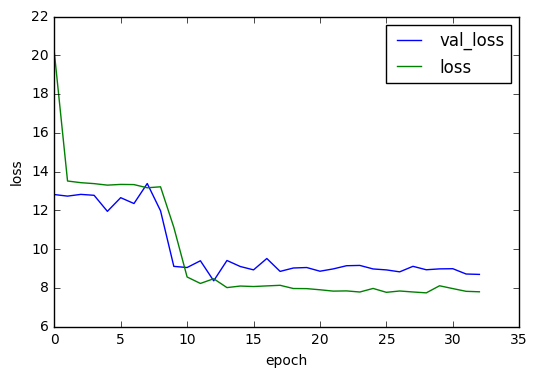

In [36]:
plt.show()

In [37]:
plt.plot(history.history['val_mean_absolute_error'])
plt.plot(history.history['mean_absolute_error'])
plt.legend(['val_mae','mae'])
plt.xlabel('epoch')
plt.ylabel('mae')

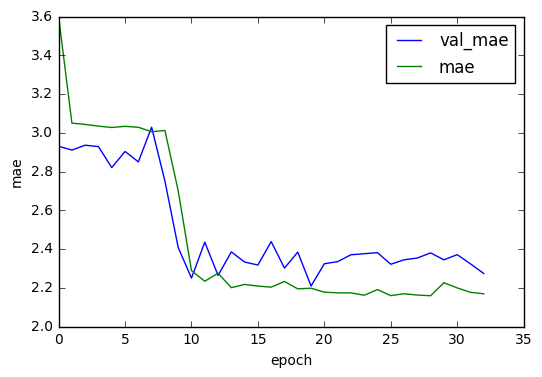

In [38]:
plt.show()

In [39]:
from sklearn.decomposition import PCA

In [40]:
pca=PCA()
pca.fit(train_X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [42]:
pca.explained_variance_ratio_

array([8.41773856e-01, 1.49222964e-01, 5.26279957e-03, 1.81721465e-03,
       1.12249301e-03, 4.98046817e-04, 2.50758407e-04, 2.08401499e-05,
       1.08588783e-05, 6.79904160e-06, 4.10453871e-06, 3.07468120e-06,
       2.06126139e-06, 1.17673601e-06, 8.67891328e-07, 4.00856521e-07,
       3.32690160e-07, 3.21226874e-07, 2.60674223e-07, 1.99878370e-07,
       1.10475835e-07, 9.36591667e-08, 7.17837183e-08, 6.43929724e-08,
       5.57195356e-08, 3.61585929e-08, 2.35190610e-08, 2.32992475e-08,
       1.94612765e-08, 1.72480189e-08, 1.38822416e-08, 7.08823403e-09,
       5.90947644e-09, 5.00611231e-09, 3.37600856e-09, 2.81356977e-09,
       2.63027478e-09, 2.43649719e-09, 2.22062561e-09, 1.61033364e-09,
       1.41721157e-09, 1.26601484e-09, 9.39326912e-10, 7.44339191e-10,
       6.91925040e-10, 5.50009896e-10, 3.55701185e-10, 2.22826230e-10,
       1.80070273e-10, 9.94377553e-11, 9.82844590e-11, 6.75587191e-11,
       5.85109141e-11, 4.98157563e-11, 3.84947334e-11, 3.56889615e-11,
      

In [43]:
#obviously only the 

In [44]:
pca=PCA()
pca.fit(train_X_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [45]:
pca.explained_variance_ratio_

array([5.56637514e-01, 1.19698307e-01, 7.36097614e-02, 3.50717070e-02,
       2.53909130e-02, 2.27240900e-02, 2.03581466e-02, 1.71079806e-02,
       1.24504463e-02, 1.16851000e-02, 9.74178434e-03, 9.05973247e-03,
       7.99872216e-03, 7.70556247e-03, 7.58245935e-03, 6.20729873e-03,
       5.44815324e-03, 4.96681774e-03, 4.87861976e-03, 3.64293358e-03,
       3.40691134e-03, 3.36823484e-03, 3.01961454e-03, 2.81408706e-03,
       2.69277665e-03, 2.54587490e-03, 2.03298786e-03, 1.86558880e-03,
       1.64262926e-03, 1.53967156e-03, 1.34940622e-03, 1.31783524e-03,
       1.15148160e-03, 9.05607435e-04, 7.96485123e-04, 7.54704456e-04,
       6.78824775e-04, 5.97773943e-04, 5.57216529e-04, 5.11291722e-04,
       4.40587758e-04, 3.92527402e-04, 3.04914556e-04, 2.85688244e-04,
       2.37251626e-04, 2.24285709e-04, 1.96142660e-04, 1.90762603e-04,
       1.78618605e-04, 1.72912960e-04, 1.44656038e-04, 1.36317928e-04,
       1.24557520e-04, 1.02023711e-04, 9.87340052e-05, 8.99193435e-05,
      

In [46]:
#from the pca analysis, we will only use the first 32 components
pca=PCA(n_components=32)
X_dim_reduced=pca.fit_transform(train_X_scaled)

In [47]:
X_dim_reduced_transformed=X_dim_reduced.reshape(X_dim_reduced.shape[0],X_dim_reduced.shape[1],1)

In [48]:
#2 we will use dimensions reduced by PCA, then apply LSTM model to predict time_to_failure
# monitored criterion should in the metrics list for model's compile function
callbacks_earlystopping=[keras.callbacks.EarlyStopping(patience=20,monitor='val_loss')]
LSTM_model=Sequential()
LSTM_model.add(LSTM(100,input_shape=(X_dim_reduced_transformed.shape[1],
                                     X_dim_reduced_transformed.shape[2])))
LSTM_model.add(Dense(1))
LSTM_model.compile(optimizer='adam',loss='mean_squared_error',metrics=['mae'])
history=LSTM_model.fit(X_dim_reduced_transformed,train_y,epochs=500,batch_size=64,
                       validation_split=0.25,callbacks=callbacks_earlystopping,verbose=True)

Train on 4658 samples, validate on 1553 samples
Epoch 1/500
4658/4658 [==============================] - 2s 517us/step - loss: 19.8421 - mean_absolute_error: 3.5779 - val_loss: 12.8849 - val_mean_absolute_error: 2.9334
Epoch 2/500
4658/4658 [==============================] - 1s 316us/step - loss: 13.5183 - mean_absolute_error: 3.0577 - val_loss: 12.8505 - val_mean_absolute_error: 2.9211
Epoch 3/500
4658/4658 [==============================] - 2s 367us/step - loss: 13.5526 - mean_absolute_error: 3.0580 - val_loss: 13.0710 - val_mean_absolute_error: 2.9751
Epoch 4/500
4658/4658 [==============================] - 2s 351us/step - loss: 13.5091 - mean_absolute_error: 3.0536 - val_loss: 13.0211 - val_mean_absolute_error: 2.9668
Epoch 5/500
4658/4658 [==============================] - 2s 355us/step - loss: 13.5164 - mean_absolute_error: 3.0566 - val_loss: 12.8773 - val_mean_absolute_error: 2.9366
Epoch 6/500
4658/4658 [==============================] - 2s 326us/step - loss: 13.5630 - mean_abs

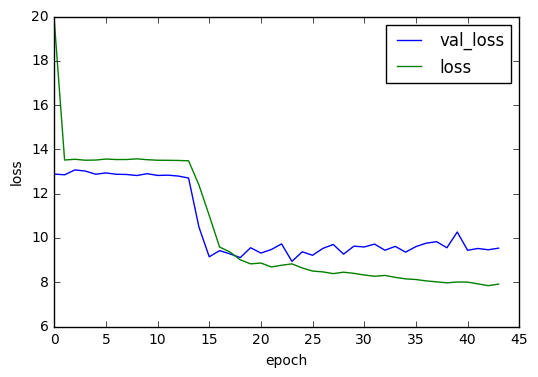

In [49]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.legend(['val_loss','loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [50]:
test_X_seg_ids=pd.read_csv('F:\\Qplus\\Kaggle\\sample_submission.csv',
                           dtype={'time_to_failure':np.float32},index_col='seg_id')
test_X=pd.DataFrame()
for seg_id in test_X_seg_ids.index.values:
    #print(type(seg_id))
    seg_data=pd.read_csv('F:\\Qplus\\Kaggle\\test\\'+seg_id+'.csv',
                         dtype={'acoustic_data':np.float32})
    test_X=test_X.append(create_many_features(seg_data.acoustic_data,seg_id=seg_id),
                         ignore_index=True)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "F:\Softwares\Anaconda\install\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-50-ddd3f8891763>", line 8, in <module>
    test_X=test_X.append(create_many_features(seg_data.acoustic_data,seg_id=seg_id),
  File "<ipython-input-8-cb923bc0b4c3>", line 134, in create_many_features
    X.loc[seg_id, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "F:\Softwares\Anaconda\install\lib\site-packages\IPython\core\interactiveshell.py", line 1821, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "F:\Softwares\Anacon

KeyboardInterrupt: 

In [92]:
scaler=StandardScaler()
scaler.fit(Merged_X)
train_X_scaled=scaler.transform(train_X)
test_X_scaled=scaler.transform(test_X)
test_X_scaled_transformed = test_X_scaled.reshape(test_X_scaled.shape[0],
                                                  test_X_scaled.shape[1], 1)

In [51]:
# test data should go through the same PCA reduction process
pca=PCA(n_components=32)
test_X_dim_reduced=pca.fit_transform(test_X_scaled)

In [52]:
test_X_dim_reduced_transformed= test_X_dim_reduced.reshape(test_X_dim_reduced.shape[0],
                                                  test_X_dim_reduced.shape[1], 1)
predict_y=LSTM_model.predict(test_X_dim_reduced_transformed)

In [53]:
predict_y[:10]

array([[7.4749517],
       [4.354404 ],
       [3.7860637],
       [5.8664513],
       [5.6832113],
       [2.109941 ],
       [7.0028234],
       [5.3850613],
       [7.1373305],
       [2.8139114]], dtype=float32)

In [54]:
submission['time_to_failure'] = predict_y
submission.to_csv('F:\\Qplus\\Kaggle\\submission_1.csv',index=True)

In [55]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

In [56]:
svr_parameters={'kernel':['linear','rbf'],
                'gamma':[0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
                'C':[0.1, 0.2, 0.25, 0.5, 1, 1.5, 2, 5]}

In [57]:
svr=SVR(kernel='rbf')
svr.fit(train_X_scaled,train_y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [58]:
svr.predict(test_X)

array([1.92820912, 1.92820912, 1.92820912])

In [73]:
svr_parameters={'kernel':['linear','rbf'],
                'gamma':[0.0001, 0.001, 0.1],
                'C':[0.1,  5, 50],
               'epsilon':[0.01,0.1,1,10]}

In [74]:
gcv=GridSearchCV(svr,param_grid=svr_parameters,scoring='neg_mean_absolute_error',cv=4)
gcv.fit(X_dim_reduced,train_y)

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'epsilon': [0.01, 0.1, 1, 10], 'C': [0.1, 5, 50], 'kernel': ['linear', 'rbf'], 'gamma': [0.0001, 0.001, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [75]:
gcv.best_params_

{'C': 5, 'epsilon': 1, 'gamma': 0.001, 'kernel': 'rbf'}

In [76]:
gcv.best_score_

-2.183331088027308

In [77]:
gcv.best_estimator_

SVR(C=5, cache_size=200, coef0=0.0, degree=3, epsilon=1, gamma=0.001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [78]:
gcv.predict(test_X_dim_reduced)

array([6.29408305, 5.00437331, 5.31831826, ..., 6.43610776, 6.62392604,
       3.63306281])